<a href="https://colab.research.google.com/github/ChoiDae1/MLP_Mixer-PyTorch/blob/main/Implementing_MLP_Mixer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 드라이브 연결
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


## Preparing dataset

In [3]:
import os
import random

data_path = "/content/drive/Shareddrives/Practical_Computer_Vision/week_2/Cat_vs_Dog"
train_dir = os.path.join(data_path, "train")
test_dir = os.path.join(data_path, "test1")
os.chdir(data_path)

test_images = os.listdir(test_dir)
image_paths = [f'train/dog.{i}.jpg' for i in range(6000)] + [f'train/cat.{i}.jpg' for i in range(6000)]
random.shuffle(image_paths)

In [4]:
import pandas as pd 
import numpy  as np

def list_full_paths(directory):
    return [os.path.join(directory, file) for file in os.listdir(directory)]

train = pd.DataFrame({'filepath': image_paths})
train['truth_label'] = np.where(train['filepath'].str.contains('dog'), 1, 0) # dog=1, cat=0

test = pd.DataFrame({'filepath': test_images})

In [5]:
print(train.head())
print(train.shape)

             filepath  truth_label
0    train/dog.22.jpg            1
1  train/dog.4804.jpg            1
2  train/cat.1859.jpg            0
3  train/dog.4342.jpg            1
4   train/dog.397.jpg            1
(12000, 2)


In [6]:
print(sum(train['truth_label']==1)) # dog label 개수
print(sum(train['truth_label']==0)) # cat label 개수

6000
6000


In [7]:
from sklearn.model_selection import train_test_split

train_set, val_set = train_test_split(train, test_size=0.1)

In [8]:
print(train_set.shape, val_set.shape)

(10800, 2) (1200, 2)


## PyTorch Dataset, DataLoader

In [9]:
from PIL import Image
import torchvision

img = Image.open(list(train_set['filepath'])[100])
img = img.resize((224, 224))
tensor = torchvision.transforms.ToTensor()
img = tensor(img)
print(img.shape)
view_img = img.view(-1)
print(sum((view_img>1)|(view_img<0))) #이미 정규화되어있음

torch.Size([3, 224, 224])
tensor(0)


In [10]:
#dataset
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T

class Dog_Cat_Dataset(Dataset):
    def __init__(self, annotation_data, transform=None, target_transform=None):
        self.img_labels = list(annotation_data['truth_label'])
        self.img = list(annotation_data['filepath'])
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        image = Image.open(self.img[idx])
        image = image.resize((224, 224))
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# tranform
def get_train_transform():
    return T.Compose([
        T.ToTensor(),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(15),
        #T.RandomCrop(204),
    ])
    
def get_val_transform():
    return T.Compose([
        T.ToTensor(),
    ])


In [11]:
train_data = Dog_Cat_Dataset(train_set, transform=get_train_transform())
val_data = Dog_Cat_Dataset(val_set, transform=get_val_transform())

In [12]:
# DataLoader
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=24, shuffle=True)
test_loader = DataLoader(val_data, batch_size=24, shuffle=False)

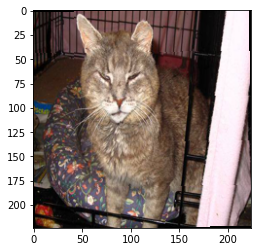

torch.Size([24, 3, 224, 224])
tensor(0)


In [13]:
# 데이터로더 잘 작동하는지 테스트
import matplotlib.pyplot as plt
import torch

# train_loader
train_imgs, train_labels = next(iter(train_loader))
plt.imshow(torch.permute(train_imgs[0],(1,2,0)).numpy())
plt.show()
print(train_imgs.shape)
print(train_labels[0])

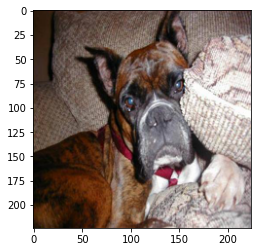

torch.Size([24, 3, 224, 224])
tensor(1)


In [14]:
# test_loader
test_imgs, test_labels = next(iter(test_loader))
plt.imshow(torch.permute(test_imgs[0],(1,2,0)).numpy())
plt.show()
print(test_imgs.shape)
print(test_labels[0])

## implementing MLP_Mixer
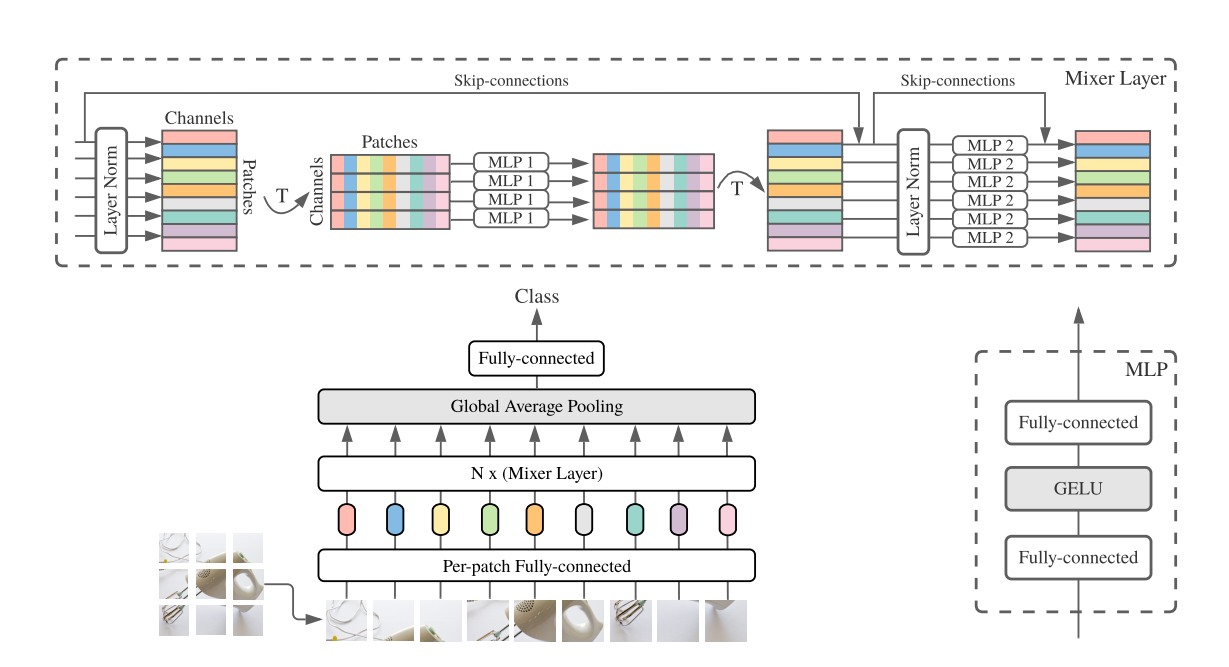

In [15]:
!pip install einops

In [16]:
import torch.nn as nn
from einops.layers.torch import Rearrange, Reduce

# patch_embedding
def patch_embedding(patch_size, hidden_size, img_channels):
    channels = np.square(patch_size)*img_channels # num_patches, assume img's channel 3
    return nn.Sequential(Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
                         nn.Linear(channels, hidden_size))
        

# MLP
def mlp(input_dim, mid_dim, dropout=0.):
    return nn.Sequential(nn.Linear(input_dim, mid_dim),
                         nn.GELU(),
                         nn.Dropout(dropout),
                         nn.Linear(mid_dim, input_dim),
                         nn.Dropout(dropout))

# Mixer_layer
class Mixer_layer(nn.Module):
    def __init__(self, channels, patches, dimension_s, dimension_c , mlp):
      super().__init__()
      self.norm = nn.LayerNorm(channels)
      self.channels = channels
      self.patches = patches
      self.token_mixing = mlp(patches, dimension_s) # token_mixing_mlp block
      self.channel_mixing = mlp(channels, dimension_c) # channel_mixing_mlp block
  
    def forward(self, input_1):
      x = self.norm(input_1)
      x = torch.transpose(x, 1, 2) # batch * channels * patches
      x = self.token_mixing(x)
      input_2 = torch.transpose(x, 1, 2) + input_1 # batch * patches * channels, skip_connection
      x = self.norm(input_2)
      x = self.channel_mixing(x)
      out = x + input_2
      return out  # batch * patches * channels


In [17]:
class MLP_Mixer(nn.Module):
    def __init__(self, img_size, patch_size, num_layers, hidden_size, dimension_s, dimension_c, num_classes):
        super().__init__()
        c, h, w = img_size
        sequence_length = (h*w)//np.square(patch_size)
        self.num_layers = num_layers
        self.patch_embedding = patch_embedding(patch_size, hidden_size, c)
        self.Mixer_layers = nn.Sequential(*[Mixer_layer(hidden_size, sequence_length, dimension_s, dimension_c, mlp) for _ in range(num_layers)])
        self.avg_pool = Reduce('b n c -> b c', 'mean')
        self.fc = nn.Sequential(nn.Linear(hidden_size, num_classes),
                                nn.Sigmoid()) # Binary classification 이므로
    
    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.Mixer_layers(x)
        x = self.avg_pool(x)
        x = self.fc(x)
        return x    


## Training & Test MLP-Mixer

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device) 

cuda


In [19]:
mixer = MLP_Mixer(img_size=(3, 224, 224), patch_size=16, num_layers=8, hidden_size=512, dimension_s=256, dimension_c=2048, num_classes=1).to(device) #논문에서 S/16에 해당

In [20]:
import torch.optim as optim

loss_func = nn.BCELoss()
optimizer = optim.Adam(mixer.parameters(), lr=1e-3) 

In [21]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X, y = X.to(device), y.to(device)
        y = y.float()
        pred = model(X).squeeze()
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y = y.float()
            pred = model(X).squeeze()
            test_loss += loss_fn(pred, y).item()
            label_pred = torch.where(pred > 0.5, 1, 0)
            correct += (label_pred == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [22]:
num_epochs = 3

#training
for t in range(num_epochs):
    print(f'Epoch {t+1}\n---------------------')
    train_loop(train_loader, mixer, loss_func , optimizer)
    test_loop(test_loader, mixer, loss_func)
print("Done!")


Epoch 1
---------------------
loss: 0.719738  [    0/10800]
loss: 0.698456  [ 2400/10800]
loss: 0.698871  [ 4800/10800]
loss: 0.665111  [ 7200/10800]
loss: 0.672786  [ 9600/10800]
Test Error: 
 Accuracy: 59.0%, Avg loss: 0.671356 

Epoch 2
---------------------
loss: 0.708485  [    0/10800]
loss: 0.526064  [ 2400/10800]
loss: 0.640451  [ 4800/10800]
loss: 0.697280  [ 7200/10800]
loss: 0.643761  [ 9600/10800]
Test Error: 
 Accuracy: 61.3%, Avg loss: 0.656296 

Epoch 3
---------------------
loss: 0.625814  [    0/10800]
loss: 0.795046  [ 2400/10800]
loss: 0.705054  [ 4800/10800]
loss: 0.732986  [ 7200/10800]
loss: 0.644968  [ 9600/10800]
Test Error: 
 Accuracy: 62.3%, Avg loss: 0.648620 

Done!
